Install libraries

In [1]:
%pip install requests
%pip install pandas
%pip install numpy
%pip install scikit-learn
%pip install statsmodels
%pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to us

In [2]:
import requests
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot as plt

Get hourly weather data with ETL framework

In [3]:
parameters = {"ids": "KSBA",
              "format": "json",
              "taf": "false",
              "hours": 1000}
url = "https://aviationweather.gov/api/data/metar"
data = requests.get(url, params = parameters).json()
df = pd.json_normalize(data)
df.head()

,metar_id,icaoId,receiptTime,obsTime,reportTime,temp,dewp,wdir,wspd,wgst,...,vertVis,metarType,rawOb,mostRecent,lat,lon,elev,prior,name,clouds
0,539916854,KSBA,2024-05-03 21:58:17,1714773180,2024-05-03 22:00:00,16.1,13.3,250,8,NaN,...,NaN,METAR,KSBA 032153Z 25008KT 8SM BKN021 OVC030 16/13 A...,1,34.4241,-119.842,2,3,"Santa Barbara Muni, CA, US","[{'cover': 'BKN', 'base': 2100}, {'cover': 'OV..."
1,539897636,KSBA,2024-05-03 21:00:09,1714769580,2024-05-03 21:00:00,15.6,13.3,250,8,NaN,...,NaN,METAR,KSBA 032053Z COR 25008KT 8SM OVC030 16/13 A299...,0,34.4241,-119.842,2,3,"Santa Barbara Muni, CA, US","[{'cover': 'OVC', 'base': 3000}]"
2,539877992,KSBA,2024-05-03 20:04:05,1714766400,2024-05-03 20:00:00,16.1,13.9,260,6,NaN,...,NaN,SPECI,KSBA 032000Z 26006KT 9SM OVC030 16/14 A2991 RM...,0,34.4241,-119.842,2,3,"Santa Barbara Muni, CA, US","[{'cover': 'OVC', 'base': 3000}]"
3,539873155,KSBA,2024-05-03 19:58:08,1714765980,2024-05-03 20:00:00,16.7,13.9,250,6,NaN,...,NaN,METAR,KSBA 031953Z 25006KT 9SM BKN018 OVC030 17/14 A...,0,34.4241,-119.842,2,3,"Santa Barbara Muni, CA, US","[{'cover': 'BKN', 'base': 1800}, {'cover': 'OV..."
4,539851616,KSBA,2024-05-03 18:58:13,1714762380,2024-05-03 19:00:00,16.7,13.9,240,3,NaN,...,NaN,METAR,KSBA 031853Z 24003KT 9SM BKN012 OVC017 17/14 A...,0,34.4241,-119.842,2,3,"Santa Barbara Muni, CA, US","[{'cover': 'BKN', 'base': 1200}, {'cover': 'OV..."


Convert observation time and temperature into UTC and Fahrenheit units

In [4]:
df["UTC"] = pd.to_datetime(df["obsTime"], unit = "s")
df["Temperature"] = np.round(np.array(df["temp"])*1.8 + 32, 0)
df = df.drop(["clouds","obsTime","temp"], axis = 1)
df.head()

,metar_id,icaoId,receiptTime,reportTime,dewp,wdir,wspd,wgst,visib,altim,...,metarType,rawOb,mostRecent,lat,lon,elev,prior,name,UTC,Temperature
0,539916854,KSBA,2024-05-03 21:58:17,2024-05-03 22:00:00,13.3,250,8,NaN,8,1012.6,...,METAR,KSBA 032153Z 25008KT 8SM BKN021 OVC030 16/13 A...,1,34.4241,-119.842,2,3,"Santa Barbara Muni, CA, US",2024-05-03 21:53:00,61.0
1,539897636,KSBA,2024-05-03 21:00:09,2024-05-03 21:00:00,13.3,250,8,NaN,8,1013.0,...,METAR,KSBA 032053Z COR 25008KT 8SM OVC030 16/13 A299...,0,34.4241,-119.842,2,3,"Santa Barbara Muni, CA, US",2024-05-03 20:53:00,60.0
2,539877992,KSBA,2024-05-03 20:04:05,2024-05-03 20:00:00,13.9,260,6,NaN,9,1013.0,...,SPECI,KSBA 032000Z 26006KT 9SM OVC030 16/14 A2991 RM...,0,34.4241,-119.842,2,3,"Santa Barbara Muni, CA, US",2024-05-03 20:00:00,61.0
3,539873155,KSBA,2024-05-03 19:58:08,2024-05-03 20:00:00,13.9,250,6,NaN,9,1013.3,...,METAR,KSBA 031953Z 25006KT 9SM BKN018 OVC030 17/14 A...,0,34.4241,-119.842,2,3,"Santa Barbara Muni, CA, US",2024-05-03 19:53:00,62.0
4,539851616,KSBA,2024-05-03 18:58:13,2024-05-03 19:00:00,13.9,240,3,NaN,9,1013.6,...,METAR,KSBA 031853Z 24003KT 9SM BKN012 OVC017 17/14 A...,0,34.4241,-119.842,2,3,"Santa Barbara Muni, CA, US",2024-05-03 18:53:00,62.0


In [5]:
x = np.array(df["Temperature"]).reshape(-1, 1)

In [6]:
clusters = DBSCAN(eps=1, min_samples=12).fit_predict(x)
print(clusters)

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0 -1 -1 -1 -1  0  0  0  0  0  0 -1  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1 -1  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

In [7]:
df = df[["UTC","Temperature"]].assign(Anomaly = clusters)

In [8]:
df.head()

,UTC,Temperature,Anomaly
0,2024-05-03 21:53:00,61.0,0
1,2024-05-03 20:53:00,60.0,0
2,2024-05-03 20:00:00,61.0,0
3,2024-05-03 19:53:00,62.0,0
4,2024-05-03 18:53:00,62.0,0


In [9]:
df.loc[(df["Anomaly"] == -1),:]

,UTC,Temperature,Anomaly
102,2024-04-30 07:53:00,70.0,-1
103,2024-04-30 06:53:00,72.0,-1
104,2024-04-30 05:53:00,73.0,-1
105,2024-04-30 05:22:00,73.0,-1
112,2024-04-29 22:53:00,69.0,-1
160,2024-04-27 23:53:00,70.0,-1
161,2024-04-27 22:53:00,70.0,-1
162,2024-04-27 21:53:00,69.0,-1
186,2024-04-26 21:53:00,70.0,-1
187,2024-04-26 20:53:00,74.0,-1


# Time Series Decomposition

In [11]:
result = seasonal_decompose(df["Temperature"], model = 'additive', period = 24)

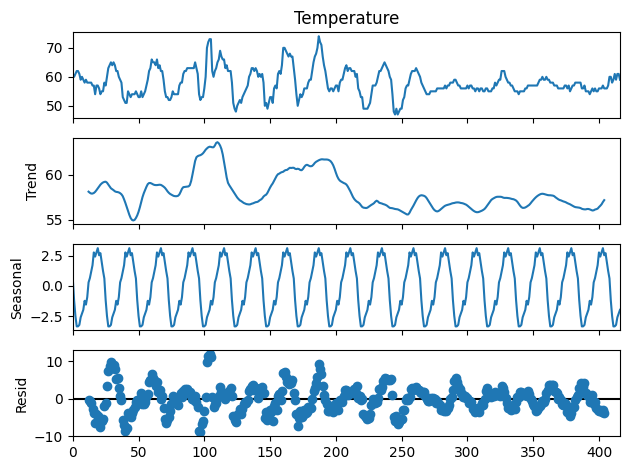

In [12]:
result.plot()
plt.show()